In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [2]:
FILE_PATH = 'train.csv'
TARGET_COLUMN = 'Cover_Type'

In [3]:
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [4]:
try:
    data = pd.read_csv(FILE_PATH)
    print(f"Data loaded successfully. Shape: {data.shape}")
except FileNotFoundError:
    print(f"Error: File not found at '{FILE_PATH}'. Please upload your dataset and rename it if necessary.")
    data = None

if data is not None:
    # Display the first few rows and information
    print("\nFirst 5 rows of the dataset:")
    print(data.head())
    print("\nDataset Information:")
    data.info()

Data loaded successfully. Shape: (15120, 56)

First 5 rows of the dataset:
   Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   1       2596      51      3                               258   
1   2       2590      56      2                               212   
2   3       2804     139      9                               268   
3   4       2785     155     18                               242   
4   5       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232      


Missing values check:
0

Target Variable ('Cover_Type') Distribution:
Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
Name: count, dtype: int64


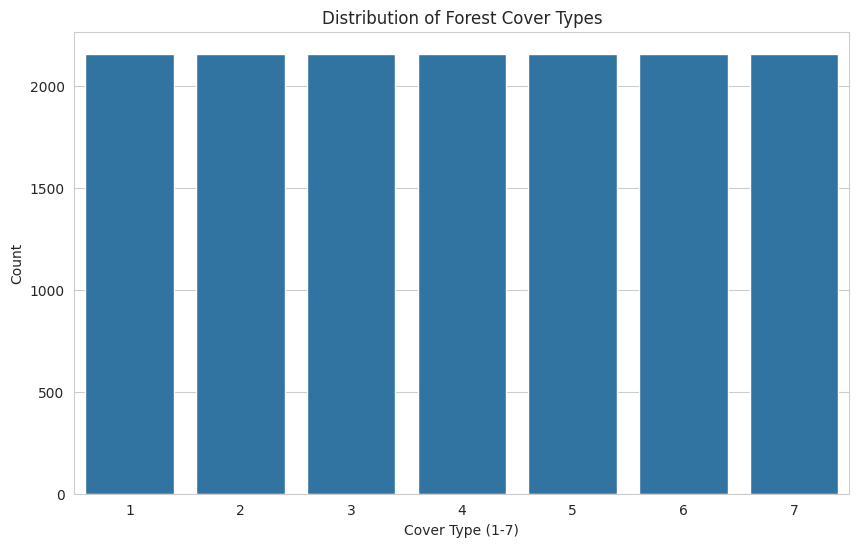

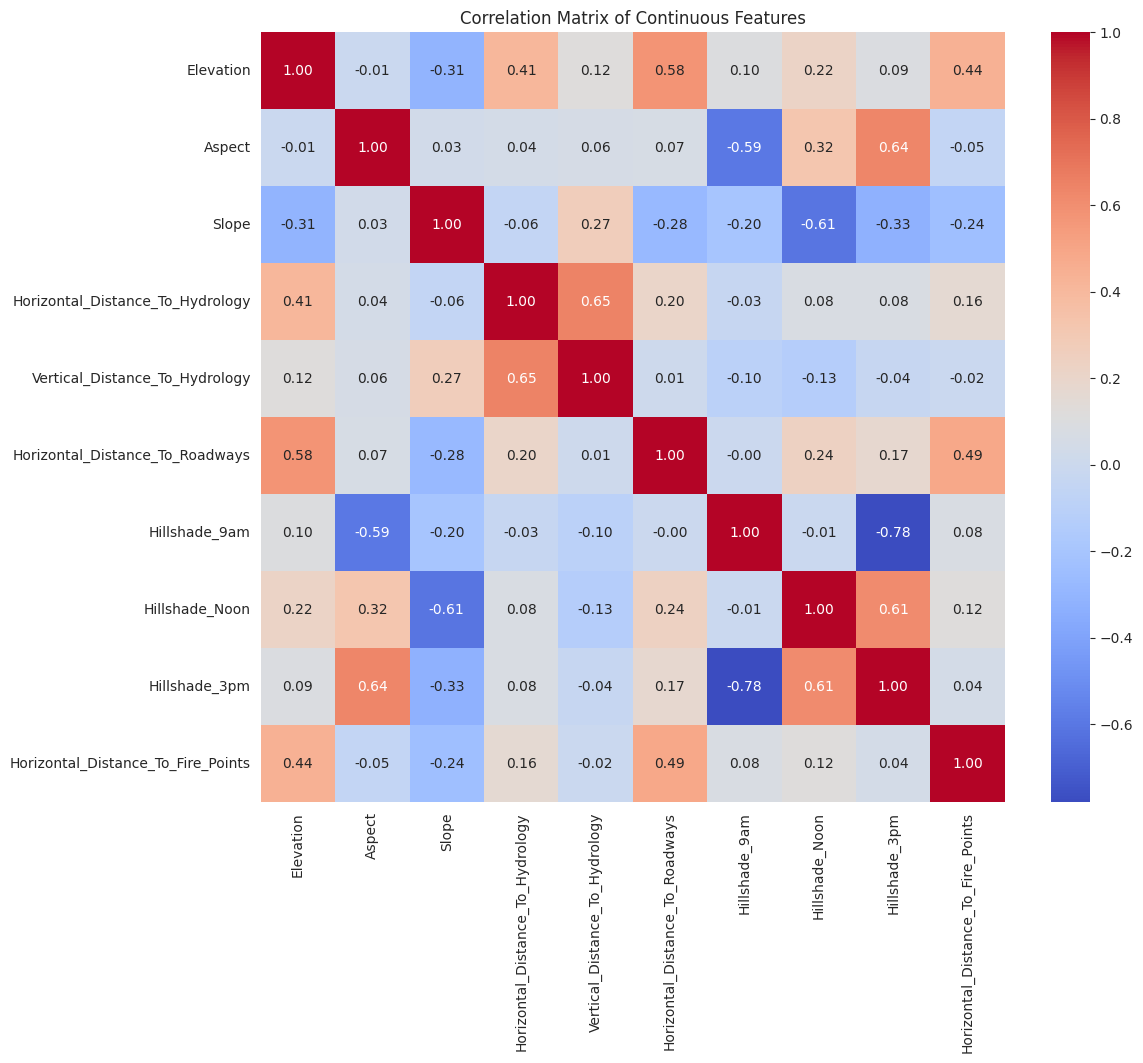

In [5]:
if data is not None:
    # Check for missing values
    print("\nMissing values check:")
    print(data.isnull().sum().sum())  # Sum of all missing values (should be 0)

    # Drop the 'Id' column as it's just an identifier
    data = data.drop('Id', axis=1)

    # Analyze the target distribution
    print(f"\nTarget Variable ('{TARGET_COLUMN}') Distribution:")
    target_counts = data[TARGET_COLUMN].value_counts().sort_index()
    print(target_counts)

    plt.figure(figsize=(10, 6))
    sns.countplot(x=TARGET_COLUMN, data=data)
    plt.title('Distribution of Forest Cover Types')
    plt.xlabel('Cover Type (1-7)')
    plt.ylabel('Count')
    plt.show()

    # Correlation analysis for non-binary features
    non_binary_cols = data.columns[:10]  # First 10 columns are numerical/continuous
    plt.figure(figsize=(12, 10))
    sns.heatmap(data[non_binary_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Continuous Features')
    plt.show()

In [6]:
if data is not None:
    # 1. Feature Engineering: Distance to Hydrology
    # Manhattan Distance (L1 norm) is often better than Euclidean here
    data['Hydro_Manhattan_Dist'] = abs(data['Horizontal_Distance_To_Hydrology']) + abs(data['Vertical_Distance_To_Hydrology'])
    data['Hydro_Euclidean_Dist'] = np.sqrt(data['Horizontal_Distance_To_Hydrology']**2 + data['Vertical_Distance_To_Hydrology']**2)

    # 2. Feature Engineering: Combined Hillshade
    # Hillshade_3pm can be negatively correlated with cover type, so let's adjust the indices
    data['Hillshade_Index'] = (data['Hillshade_9am'] + data['Hillshade_Noon'] + data['Hillshade_3pm']) / 3

    # 3. Feature Engineering: Elevation * Vertical Distance to Hydrology interaction
    # This might capture the effect of elevation relative to water sources
    data['Elev_Hyd_Interaction'] = data['Elevation'] * data['Vertical_Distance_To_Hydrology']

    # 4. Handle Aspect (Azimuth in degrees): It is circular (360 degrees = 0 degrees)
    # We use sine and cosine transformations to represent it correctly
    data['Aspect_sin'] = np.sin(np.deg2rad(data['Aspect']))
    data['Aspect_cos'] = np.cos(np.deg2rad(data['Aspect']))
    data = data.drop('Aspect', axis=1) # Drop original Aspect

    # Separate features (X) and target (y)
    X = data.drop(TARGET_COLUMN, axis=1)
    y = data[TARGET_COLUMN]

    # Scaling numerical features (excluding binary/one-hot and engineered sin/cos features)
    numerical_features = ['Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology',
                          'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
                          'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
                          'Horizontal_Distance_To_Fire_Points',
                          'Hydro_Manhattan_Dist', 'Hydro_Euclidean_Dist', 'Hillshade_Index',
                          'Elev_Hyd_Interaction']

    scaler = StandardScaler()
    X[numerical_features] = scaler.fit_transform(X[numerical_features])

    print("\nFeatures after engineering and scaling:")
    print(X.head())


Features after engineering and scaling:
   Elevation     Slope  Horizontal_Distance_To_Hydrology  \
0  -0.367095 -1.597132                          0.146639   
1  -0.381461 -1.715424                         -0.072337   
2   0.130912 -0.887379                          0.194243   
3   0.085421  0.177250                          0.070474   
4  -0.369489 -1.715424                         -0.353198   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                       -0.834074                        -0.908681   
1                       -0.932054                        -0.999246   
2                        0.227369                         1.106379   
3                        1.092853                         1.038455   
4                       -0.850404                        -0.998491   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0       0.271454        0.571653       0.281259   
1       0.238732        0.703225       0.346627   
2       0.696843        

In [7]:
if data is not None:
    # Split the data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")

    # Initialize and train the Random Forest Classifier
    # We use a modest number of estimators for faster initial training
    model = RandomForestClassifier(n_estimators=200,
                                   max_depth=20,
                                   min_samples_split=5,
                                   random_state=42,
                                   n_jobs=-1,
                                   class_weight='balanced') # Use class_weight to help with potential imbalance

    print("\nStarting model training...")
    model.fit(X_train, y_train)
    print("Model training complete.")


Training set shape: (12096, 59), Test set shape: (3024, 59)

Starting model training...
Model training complete.



Overall Test Accuracy: 0.8370

Classification Report:
                   precision    recall  f1-score   support

       Spruce/Fir       0.76      0.76      0.76       432
   Lodgepole Pine       0.78      0.61      0.69       432
   Ponderosa Pine       0.81      0.76      0.78       432
Cottonwood/Willow       0.92      0.97      0.94       432
            Aspen       0.86      0.94      0.90       432
      Douglas-fir       0.78      0.86      0.82       432
        Krummholz       0.93      0.96      0.95       432

         accuracy                           0.84      3024
        macro avg       0.83      0.84      0.83      3024
     weighted avg       0.83      0.84      0.83      3024



/tmp/ipython-input-2890959720.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_features.values, y=top_20_features.index, palette='viridis')


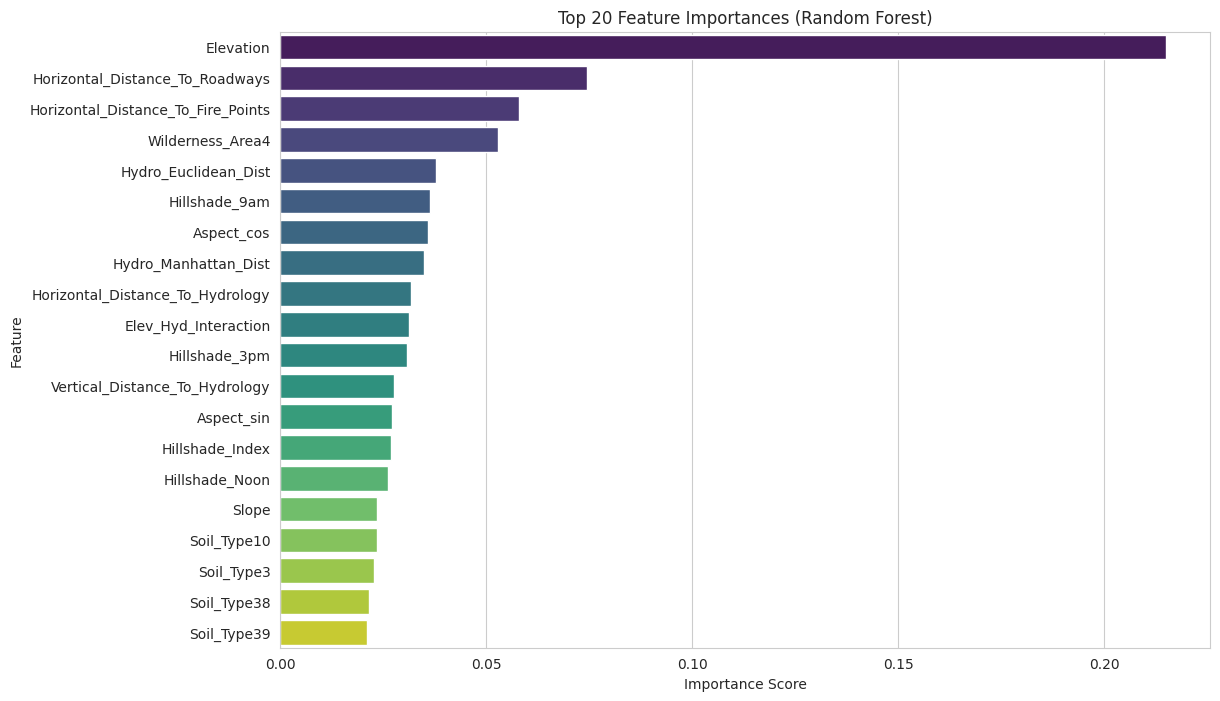


--- Model Summary ---
Top 3 Most Important Features: ['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']
The model can now be used to predict the Cover Type for new, unseen data.


In [8]:
if data is not None:
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate overall accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nOverall Test Accuracy: {accuracy:.4f}")

    # Generate a detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=[
        'Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine',
        'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz'
    ]))

    # Feature Importance Visualization
    feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    top_20_features = feature_importances.nlargest(20)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_20_features.values, y=top_20_features.index, palette='viridis')
    plt.title('Top 20 Feature Importances (Random Forest)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()

    print("\n--- Model Summary ---")
    print(f"Top 3 Most Important Features: {top_20_features.index[:3].tolist()}")
    print("The model can now be used to predict the Cover Type for new, unseen data.")